This notebook tries to implement the paper **Local Relation Networks for Image Recognition** by **Han Hu et. .al.** in Pytorch. [[paper](https://arxiv.org/pdf/1904.11491.pdf)]

In [0]:
import torch
from IPython.display import Image

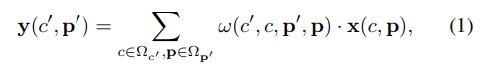

In [16]:
Image(filename='generic.PNG')

The paper formulates any aggregation layer as of the form given above. For example if it where a conv2d layer the weight would be the kernel. 

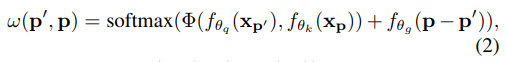

In [17]:
Image(filename='lr.PNG')

This formulation for the Local Relation Layer has a few quirks and features. First thing you'll notice is that the k x k kernel applied varies depending on the input. That is usually bad, we usually share the parameters so that they can be learned efficiently. The weights here are generated based on the input and shared parameters for the function $f_i$. 
One particular feature of this layer is that performance improves with larger kernel size and doesn't saturate at 3 x 3 like conv2d layer. It can go up to 7 x7.

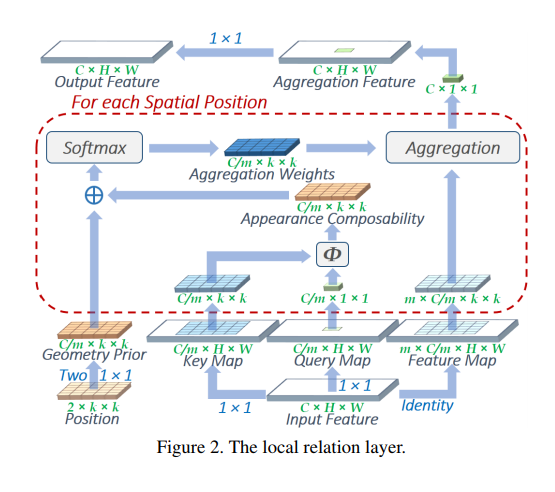

In [18]:
Image(filename='full_lr.PNG')

Lets start implementing the modules needed shown above for the layer one by one. 

In [0]:
class GeometryPrior(torch.nn.Module):
    def __init__(self, k, channels, multiplier=0.5):
        super(GeometryPrior, self).__init__()
        self.channels = channels
        self.k = k
        self.position = 2 * torch.rand(1, 2, k, k, requires_grad=True) - 1
        self.l1 = torch.nn.Conv2d(2, int(multiplier * channels), 1)
        self.l2 = torch.nn.Conv2d(int(multiplier * channels), channels, 1)
        
    def forward(self, x):
        x = self.l2(torch.nn.relu(self.l1(self.position)))
        return x.view(1, channels, 1, self.k ** 2)

The above module is for training the Geometry Prior. The paper states that instead of learning the prior weight directly they have a mini-network to help learn weights directly. Since if the weights are fixed for this mini-network, the output is deterministic independant of the image. So after training we can just always return that value instead of running this mini network. 

In [0]:
class KeyQueryMap(torch.nn.Module):
    def __init__(self, channels, reduced_channels):
        super(KeyQueryMap, self).__init__()
        self.l = torch.nn.Conv2d(channels, reduced_channels, 1)
    
    def forward(self, x):
        return self.l(x)

Both the Key and Query Maps are generated in the same way so I write one class which will have different instances for each. 

In [0]:
class AppearanceComposability(torch.nn.Module):
    def __init__(self, k, padding):
        super(AppearanceComposability, self).__init__()
        self.k = k
        self.unfold = torch.nn.Unfold(k, 1, padding, 1)
    
    def forward(self, x):
        key_map, query_map = x
        k = self.k
        key_map_unfold = self.unfold(key_map)
        query_map_unfold = self.unfold(query_map)
        key_map_unfold = key_map_unfold.view(
                    key_map.shape[0], key_map.shape[1],
                    key_map_unfold.shape[-2] // key_map.shape[1],
                    k ** 2)
        query_map_unfold = query_map_unfold.view(
                    key_map.shape[0], key_map.shape[1],
                    key_map_unfold.shape[-2] // key_map.shape[1],
                    k ** 2)
        return key_map_unfold * query_map_unfold[:, :, :, k**2//2:k**2//2+1]

Now that we have the kernels for Appearance and Geometry, we can combine them and then do the convolution by unfolding. 

In [0]:
def combine_prior(appearance_kernel, geometry_kernel):
    return torch.nn.functional.softmax(appearance_kernel + geometry_kernel,
                                       dim=-1)

Now that we have the final kernel for all positions, we need to just apply this on the unfolded input image. Also we will need to do it repeatedly for each of the m groups we split input into. 